**Using autoencoders to detect apples from Kaggle fruits dataset**

In [1]:
#Importing Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Activation, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.neighbors import KernelDensity

Using TensorFlow backend.
C:\Users\alber\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alber\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alber\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alber\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
%matplotlib inline

In [3]:
#Data Preprocessing - creating generators for training, validation and testing
batch_size= 85
train_datagen= ImageDataGenerator(rescale= 1./255, data_format="channels_last")
train_gen= train_datagen.flow_from_directory('E:/kaggle_fruits-360/apple_train/', target_size=(96,96), batch_size=batch_size, class_mode='input')

val_datagen= ImageDataGenerator(rescale= 1./255, data_format="channels_last")
val_gen= val_datagen.flow_from_directory('E:/kaggle_fruits-360/apple_test/', target_size=(96,96), batch_size=batch_size, class_mode='input')

anomaly_datagen= ImageDataGenerator(rescale= 1./255, data_format="channels_last")
anomaly_gen= anomaly_datagen.flow_from_directory('E:/kaggle_fruits-360/anomaly/', target_size=(96,96), batch_size=batch_size, class_mode='input')

Found 6497 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.
Found 607 images belonging to 4 classes.


In [4]:
# CNN Autoencoder modeling

model= Sequential()
#################### Encoder ####################
'16 conv- maxpooling- 8 conv-maxpooling-3 conv -max pooling- 8 conv - up sample- 3 up sample - 3 sample'

model.add(Conv2D(16, kernel_size=(3,3),  padding= 'same', activation= 'relu', input_shape=(96,96,3)))
model.add(MaxPooling2D(pool_size=(4,4), padding= 'same'))

model.add(Conv2D(8, kernel_size=(3,3),  padding= 'same', activation= 'relu', input_shape=(96,96,3)))
model.add(MaxPooling2D(pool_size=(4,4), padding= 'same'))

model.add(Conv2D(3, kernel_size=(3,3),  padding= 'same', activation= 'relu', input_shape=(96,96,3)))
model.add(MaxPooling2D(pool_size=(2,2), padding= 'same'))

#################### Decoder ####################
model.add(Conv2D(3, kernel_size=(3,3),  padding= 'same', activation= 'relu', input_shape=(96,96,3)))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(8, kernel_size=(3,3),  padding= 'same', activation= 'relu', input_shape=(96,96,3)))
model.add(UpSampling2D((4,4)))

model.add(Conv2D(16, kernel_size=(3,3),  padding= 'same', activation= 'relu', input_shape=(96,96,3)))
model.add(UpSampling2D((4,4)))

model.add(Conv2D(3, kernel_size=(3,3),  padding= 'same', activation= 'sigmoid'))

##################################################

model.summary()
model.compile(optimizer='adadelta', loss= 'mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 3)           219       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 3)          

In [5]:
# Training the model

early_stopping=keras.callbacks.EarlyStopping(monitor= 'val_loss', mode= 'min',  patience= 30)
model_filepath='C:/Users/alber/autoencoder.keras'
best_model= keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min')
model.fit_generator(train_gen, steps_per_epoch=1000 // batch_size, epochs=600, 
                    validation_data= val_gen, validation_steps= 1000 // batch_size, shuffle= True, 
                    callbacks= [early_stopping, best_model])


Epoch 1/600
11/11 [==============================] - 19s 2s/step - loss: 0.1211 - val_loss: 0.1215
Epoch 2/600
11/11 [==============================] - 17s 2s/step - loss: 0.1185 - val_loss: 0.1139
Epoch 3/600
11/11 [==============================] - 17s 2s/step - loss: 0.1149 - val_loss: 0.1129
Epoch 4/600
11/11 [==============================] - 17s 2s/step - loss: 0.1128 - val_loss: 0.1144
Epoch 5/600
11/11 [==============================] - 17s 2s/step - loss: 0.1081 - val_loss: 0.1059
Epoch 6/600
11/11 [==============================] - 16s 1s/step - loss: 0.0993 - val_loss: 0.0948
Epoch 7/600
11/11 [==============================] - 17s 2s/step - loss: 0.0932 - val_loss: 0.0870
Epoch 8/600
11/11 [==============================] - 17s 2s/step - loss: 0.0892 - val_loss: 0.0853
Epoch 9/600
11/11 [==============================] - 17s 2s/step - loss: 0.0807 - val_loss: 0.0806
Epoch 10/600
11/11 [==============================] - 16s 1s/step - loss: 0.0775 - val_loss: 0.0754
Epoch 11/

11/11 [==============================] - 11s 989ms/step - loss: 0.0279 - val_loss: 0.0304
Epoch 83/600
11/11 [==============================] - 11s 977ms/step - loss: 0.0292 - val_loss: 0.0302
Epoch 84/600
11/11 [==============================] - 11s 997ms/step - loss: 0.0294 - val_loss: 0.0277
Epoch 85/600
11/11 [==============================] - 11s 958ms/step - loss: 0.0286 - val_loss: 0.0298
Epoch 86/600
11/11 [==============================] - 11s 967ms/step - loss: 0.0283 - val_loss: 0.0289
Epoch 87/600
11/11 [==============================] - 11s 998ms/step - loss: 0.0285 - val_loss: 0.0293
Epoch 88/600
11/11 [==============================] - 11s 1s/step - loss: 0.0277 - val_loss: 0.0273
Epoch 89/600
11/11 [==============================] - 14s 1s/step - loss: 0.0289 - val_loss: 0.0265
Epoch 90/600
11/11 [==============================] - 15s 1s/step - loss: 0.0292 - val_loss: 0.0302
Epoch 91/600
11/11 [==============================] - 13s 1s/step - loss: 0.0278 - val_loss: 0.

11/11 [==============================] - 11s 1s/step - loss: 0.0243 - val_loss: 0.0267
Epoch 164/600
11/11 [==============================] - 11s 1s/step - loss: 0.0242 - val_loss: 0.0249
Epoch 165/600
11/11 [==============================] - 11s 1s/step - loss: 0.0232 - val_loss: 0.0236
Epoch 166/600
11/11 [==============================] - 12s 1s/step - loss: 0.0245 - val_loss: 0.0244
Epoch 167/600
11/11 [==============================] - 11s 1s/step - loss: 0.0239 - val_loss: 0.0254
Epoch 168/600
11/11 [==============================] - 15s 1s/step - loss: 0.0231 - val_loss: 0.0257
Epoch 169/600
11/11 [==============================] - 14s 1s/step - loss: 0.0236 - val_loss: 0.0246
Epoch 170/600
11/11 [==============================] - 12s 1s/step - loss: 0.0229 - val_loss: 0.0251
Epoch 171/600
11/11 [==============================] - 12s 1s/step - loss: 0.0235 - val_loss: 0.0243
Epoch 172/600
11/11 [==============================] - 12s 1s/step - loss: 0.0242 - val_loss: 0.0259
Epoc

In [6]:
## Testing the model
model=keras.models.load_model(model_filepath)

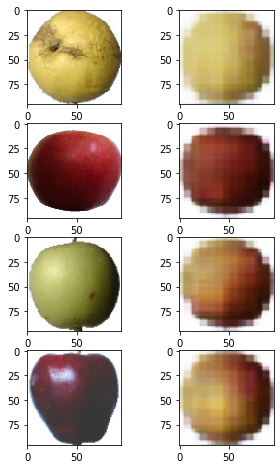

In [7]:
# Test the model by viewing a sample of original and reconstructed images
data_list = []
batch_index = 0
while batch_index <= train_gen.batch_index:
    data = train_gen.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [9]:
print(f"Error on validation set:{model.evaluate_generator(val_gen)}, error on anomaly set:{model.evaluate_generator(anomaly_gen)}")

Error on validation set:0.026400839909911156, error on anomaly set:0.03584706038236618
